# Lab 1 Report

In [1]:
import astropy.io.fits as fits
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def read_image(filename): # Function to read in the filename in the data folder and show the image of the fits file
    arr = fits.getdata(filename)
    hdr = fits.open(filename)
    hdr.info()
    hdr.close()
    plt.imshow(arr, cmap='gray', origin='lower')
    plt.title(filename)
    plt.xlabel('pixels(x)')
    plt.ylabel('pixels(y)')
    plt.show()

def get_data(filename): # Function for getting and displaying the info of the fits file
    hdr = fits.open(filename)
    return hdr[0].header['object'], hdr[0].data, hdr.close()

def mean_std(filename): # Function for computing the mean and the standard deviation of the current fits file data
    arr = fits.getdata(filename)
    x = arr.flatten()
    m1 = np.sum(x)/np.size(x) # <x> = mean
    m2 = np.sum(x**2)/np.size(x) # <x^2>
    m12 = np.absolute(m2-m1**2) # Absolute value of <x^2> - <x>^2
    std = np.sqrt(m12) # square root of <x^2> - <x>^2
    print("mean:", m1)
    print("standard deviation:", std)

def histogram(filename): # Function for creating a histogram of the desired filename
    arr = fits.getdata(filename)
    x = arr.flatten()
    hmin = 0
    hmax = x.max()
    hr = np.arange(hmin,hmax+1.)
    hist = []
    for i in hr:
        counts = len(np.where(x==i)[0])
        hist.append(counts)
    plt.plot(hr,hist)
    plt.title(filename)
    # plt.xlim(0,7000)
    plt.xlabel('counts(ADU)')
    plt.ylabel('frequency')
    plt.show()



Filename: Lab1_data/d2085.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     157   (1056, 1024)   int16 (rescales to uint16)   


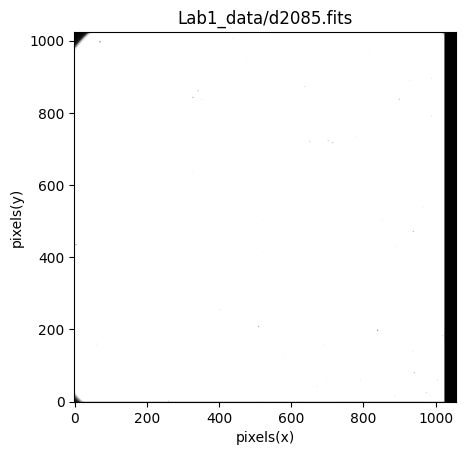

mean: 63487.85912808505
standard deviation: 63487.85011474623


KeyboardInterrupt: 

In [7]:
read_image("Lab1_data/d2085.fits")
get_data("Lab1_data/d2085.fits")
mean_std("Lab1_data/d2085.fits")
histogram("Lab1_data/d2085.fits")

In [32]:
get_data("Lab1_data/d2048.fits")



('flat',
 array([[1063, 1052, 1069, ..., 1018, 1025, 1016],
        [1113, 1092, 1096, ..., 1018, 1027, 1022],
        [1124, 1082, 1085, ..., 1023, 1027, 1017],
        ...,
        [1030, 1035, 1028, ..., 1020, 1007, 1018],
        [1035, 1035, 1037, ..., 1012, 1016, 1010],
        [1046, 1032, 1036, ..., 1003, 1004, 1014]],
       shape=(1024, 1056), dtype=uint16),
 None)

In [103]:
mean_std("Lab1_data/d2048.fits")

mean: 1946.376795913234
standard deviation: 1937.9232528893006


In [ ]:
histogram("Lab1_data/d2048.fits")

In [34]:
i = 43
xbar = []
s = []
while i<=85:
    filename = "Lab1_data/d20%d.fits"%(i)
    arr = fits.getdata(filename)
    x = arr.flatten()
    m1 = np.sum(x)/np.size(x)
    xbar.append(m1)
    m2 = np.sum(x**2)/np.size(x)
    m12 = np.absolute(m2-m1**2)
    std = np.sqrt(m12)
    s.append(std)
    i+=1

xbar = np.array(xbar)
s = np.array(s)


In [35]:
print(xbar)
print(s)

[ 2309.61505404  1622.52944022  1508.84904156  1561.65906409
  1608.62973485  1946.37679591  2001.35543268  1926.79125052
  2008.2757892   1927.34117543  4096.26098818  2830.31408969
  3421.3034335   3028.87938066  2810.92073475  5635.02506418
  7416.96276486  6303.50559766  4888.6676645   5863.41804736
  8585.34904156 10799.5416158   9431.12713346  9370.04008623
  8616.56287823 16590.81545466 16170.44714078 15333.20166293
 19810.39910334 15759.73328469 31892.60956735 29083.66966571
 29139.97419877 34104.94520615 35084.19360259 63463.12925397
 63451.38243612 63457.60425637 63368.4337898  63219.27355125
 63508.39428156 63495.05644642 63487.85912809]
[ 2302.54472666  1612.40897972  1497.96104629  1551.25584639
  1598.29662633  1937.92325289  1993.25430652  1918.19614472
  2000.22786647  1918.78868447  4092.3771736   2824.49836639
  3416.52369199  3023.50259666  2805.09842316  5632.16336022
  7414.77740766  6300.94550103  4885.31081188  5860.67095017
  8583.48301262 10798.02055246  9429.3

In [5]:
y = xbar.flatten()
mom = np.sum(y)/np.size(y)
print(mom)

20045.126123945844


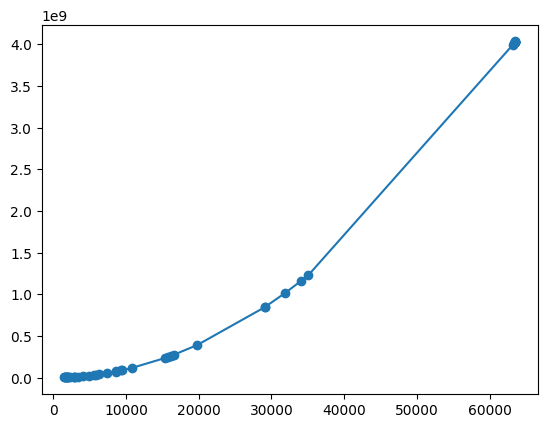

In [31]:
fig, ax = plt.subplots()
xbar.sort()
s.sort()
ax.plot(xbar,s**2,'-o')
#ax.plot(xline,yline,'-')
#plt.yscale('log')
#plt.xscale('log')
plt.show()